In [104]:
import rasterio
import glob
import tarfile
import os
import numpy as np
from geopy import distance
import matplotlib.pyplot as plt
import utm

In [18]:
direct = '/scratch/e.conway/3DReconstruction/Jacksonville/Jacksonville_Images'
files = glob.glob(direct+'/*.NTF')

In [50]:
rpcfiles = []
nwlons = []
nwlats = []
selats = []
selons = []
ntffiles = []


for file in files:
    ntffiles.append(file)
    with rasterio.open(file) as f:
        width = f.width
        height = f.height  
        
    order_id = file.split('-P1BS-')[1].split('.NTF')[0].split('_P001')[0]
    
    tar = tarfile.open(file.split('.NTF')[0]+'.tar')
    tar.extractall(file.split('.NTF')[0])
    
    subfolder = 'DVD_VOL_1'
    for x in os.listdir(file.split('.NTF')[0]+'/'+order_id):
        if 'DVD_VOL' in x:
            subfolder = x
            break
            
    des_folder = os.path.join(file.split('.NTF')[0], order_id, subfolder, order_id)
    rpcfile = glob.glob(des_folder+'/*.XML')[0]
    rpcfiles.append(rpcfile)

    with open(rpcfile,'r') as f:
        rpcdata = f.readlines()
    for line in rpcdata:
        if 'NWLAT' in line:
            NWLAT = np.float64(line.split('<NWLAT>')[1].split('</NWLAT>')[0])
        if 'NWLONG' in line:
            NWLON = np.float64(line.split('<NWLONG>')[1].split('</NWLONG>')[0])
        if 'SELAT' in line:
            SELAT = np.float64(line.split('<SELAT>')[1].split('</SELAT>')[0])
        if 'SELONG' in line:
            SELON = np.float64(line.split('<SELONG>')[1].split('</SELONG>')[0])
            
    nwlons.append(NWLON)
    nwlats.append(NWLAT)
    selats.append(SELAT)
    selons.append(SELON)

In [97]:
print(nwlons)
print(selats)

[-81.71058971 -81.70594284 -81.70878551 -81.72141186 -81.709138
 -81.71275544 -81.71220166 -81.71560309 -81.71341674 -81.71858272
 -81.71065042 -81.72593644 -81.70515401 -81.73540434 -81.71511306
 -81.71194053 -81.70974045 -81.71261759 -81.71416272 -81.70875079
 -81.71462044 -81.72418291 -81.73283814 -81.71263839 -81.71196386
 -81.71326345]
[29.29816173 29.28682489 30.23222955 30.1962715  30.23453052 30.23367767
 30.23398577 30.22516783 30.24453232 30.23252569 30.23230116 30.23242249
 30.23705342 30.23110923 30.23075314 30.23197812 30.23503531 30.21364417
 30.22664882 30.23437882 30.21119797 30.22797912 30.23278321 30.2306775
 30.23344324 30.22738323]


In [116]:
nwlons = np.array(nwlons,dtype=np.float64)
nwlats = np.array(nwlats,dtype=np.float64)
selons = np.array(selons,dtype=np.float64)
selats = np.array(selats,dtype=np.float64)

max_lon = np.max(selons) ; min_lon = np.min(nwlons)
max_lat = np.max(nwlats) ; min_lat = np.min(selats)

print(min_lon,max_lon)
print(min_lat,max_lat)

pt1 = (max_lat,max_lon)
pt2 = (max_lat,max_lon+1)
pt3 = (max_lat+1,max_lon)

vert_dist = distance.distance(pt1,pt2).km
horz_dist = distance.distance(pt1,pt3).km
print(vert_dist,horz_dist)

nres_x = 2000*1e-5 #degrees
nres_y = nres_x *(vert_dist/horz_dist) # degrees

npix_x = 2000/0.31
npix_y = 2000*(vert_dist/horz_dist)/0.31

print(npix_x,npix_y)


-81.73540434 -81.52712561
29.28682489 30.39216345
96.10434368329275 110.8676263330453
6451.612903225807 5592.507427737479


In [117]:
lon = np.arange(min_lon,max_lon,nres_x)
lat = np.arange(min_lat,max_lat,nres_y)
nlon = len(lon)
nlat = len(lat)

tile_count = np.zeros((nlat-1,nlon-1),dtype=int)

In [118]:
for i in range(nlat-1):
    lat_lower = lat[i]
    lat_upper = lat[i+1]
    for j in range(nlon-1):
        lon_left = lon[j]
        lon_right = lon[j+1]
        
        idy = np.logical_and(nwlats>=lat_upper,selats<=lat_lower)
        idx = np.logical_and(nwlons<=lon_left,selons>=lon_right)
        idf = np.logical_and(idx,idy)
        tile[i,j] = np.sum(idf)

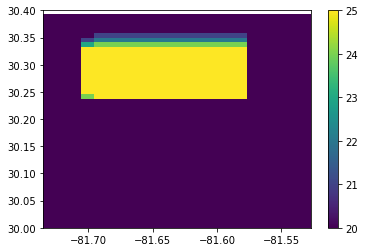

In [119]:
fig=plt.figure()
sc=plt.imshow(tile[::-1,:],aspect='auto',vmin=20,vmax=25,extent=[min_lon,max_lon,min_lat,max_lat])
plt.colorbar(sc)
plt.ylim([30,30.4])
plt.show()

In [127]:
#final tile with over N views
Viewmin=10

for i in range(nlat-1):
    lat_lower = lat[i]
    lat_upper = lat[i+1]
    for j in range(nlon-1):
        lon_left = lon[j]
        lon_right = lon[j+1]
        if(tile[i,j]>=Viewmin):
            #print(lat_upper,lon_left)
            utm_point = utm.from_latlon(lat_upper,lon_left)
            easting = utm_point[0]
            northing = utm_point[1]
            zone = utm_point[2]
            if(lat_upper>=0):
                hemi = 'N'
            else:
                hemi = 'S'
            print(easting,northing,hemi,zone)


433103.0022025613 3347543.9768646415 N 17
435027.021176564 3347532.378677428 N 17
436951.0362244663 3347521.118977862 N 17
438875.0474625215 3347510.1977611287 N 17
440799.05500698346 3347499.6150225555 N 17
442723.0589741064 3347489.370757616 N 17
433114.7554477696 3349465.1799097187 N 17
435038.4363397825 3349453.5777462376 N 17
436962.1133105769 3349442.3141864254 N 17
438885.78647626145 3349431.3892254666 N 17
440809.4559529454 3349420.80285869 N 17
442733.12185673846 3349410.5550815696 N 17
433126.51481730404 3351386.387971652 N 17
435049.8574511864 3351374.7818361428 N 17
436973.19616873254 3351363.514420199 N 17
438896.5310859064 3351352.585719007 N 17
440819.8623186726 3351341.995727895 N 17
442743.18998299626 3351331.7444423367 N 17
433138.28031013045 3353307.601052179 N 17
435061.28450977145 3353295.990948882 N 17
436984.2847979587 3353284.7196809235 N 17
438907.2812905115 3353273.78724349 N 17
440830.27410325 3353263.193631911 N 17
442753.26335199457 3353252.938841662 N 17
4